<a href="https://colab.research.google.com/github/polina-minaeva/image-classification/blob/main/3_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%80%D1%83%D0%BA%D0%BE%D0%BF%D0%B8%D1%81%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B2%D0%B2%D0%BE%D0%B4%D0%B0_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%B5_%D0%B1%D0%B0%D0%B7%D1%8B_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Загрузка библиотек

In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

2. Загрузка данных

In [ ]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=311)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [ ]:
train_label = train[:, 0] #разметка цифр

array([9., 3., 2., ..., 7., 6., 9.])

In [ ]:
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

3. Визуализация данных

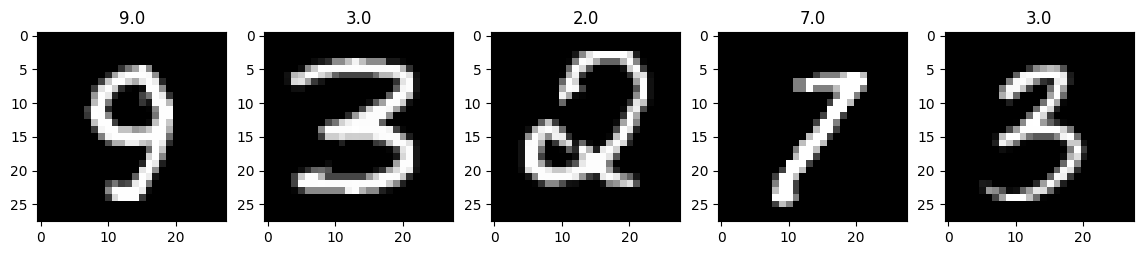

In [ ]:
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1])

4. Выражение признаков. Гистограммы градиентов

In [ ]:
'''Находим X и Y составляющие градиентов'''
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [ ]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [ ]:
'''Находим угол и длину векторов градиента'''

train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y) #Calculate the magnitude and angle of 2D vectors

In [ ]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

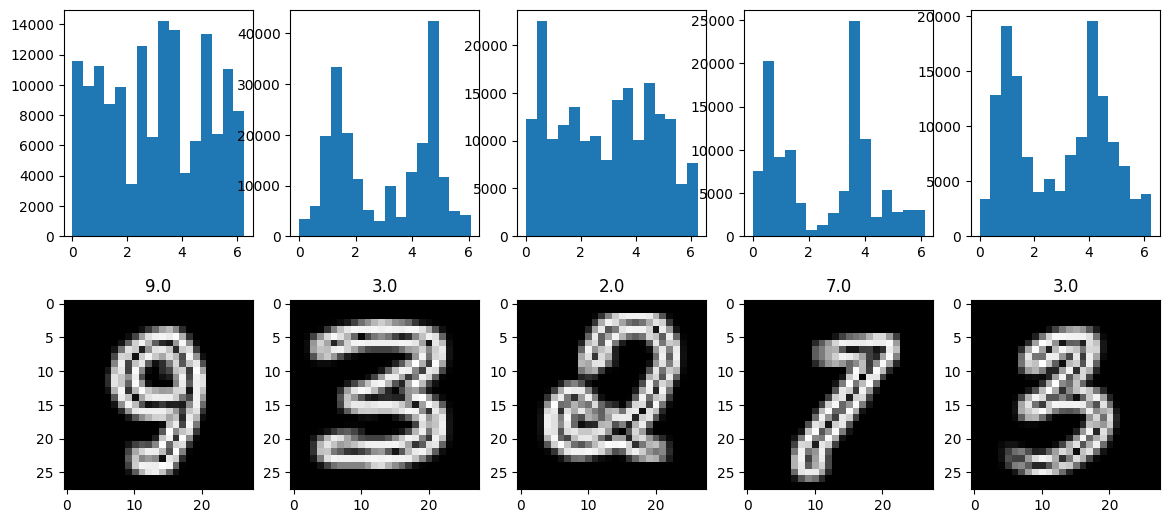

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [ ]:
len(train_img) #количество цифр, выраженных пикселями

41690

In [ ]:
'''Делаем шаблон для гистограммы'''
train_hist = np.zeros((len(train_img), 16)) #Return a new array of given shape and type, filled with zeros

'''В цикле проходимся по всем рисункам цифр'''
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [ ]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [ ]:
'''Нормируем вектор гистограммы'''
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

5. Разбиение выборки

In [ ]:
'''В качестве y используем цифры, а в качестве x - гистограммы градиентов'''

from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hist, test_size=0.2, random_state=42)

6. Построение моделей

In [ ]:
'''Задача: построить классификацию. Для начала используем модель SVC'''

from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = svm.predict(x_val)
accuracy_score(y_val, y_pred)

0.5909090909090909

In [ ]:
'''Попробуем улучшить метрику за счет изменения параметров'''

svm2 = SVC(kernel='linear', C=2.0, random_state=42)
svm2.fit(x_train, y_train)

y_pred2 = svm2.predict(x_val)
accuracy_score(y_val, y_pred2)

0.5921084192852003

In [ ]:
'''Попробуем использовать другую модель для классификации. Создаем случайный лес'''

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=42)
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [ ]:
y_pred3 = clf.predict(x_val)
accuracy_score(y_val, y_pred3)

0.6166946509954425

Метрика для случайного леса получилась лучше, чем у SVC

7. Предсказания для тестовой выборки

In [ ]:
y_pred_test = clf.predict(test_hist)

array([5., 5., 9., ..., 3., 9., 3.])

In [ ]:
with open('sample_submission.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%d\n' % (i, p))

На Kaggle итоговое предсказание оценили в 0.61685